In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

from sales_data import SalesData
from reg import LinReg, PolyReg, MultiReg
plt.style.use('ggplot')

# Import Data and Format Columns
... then aggregate data to monthly.

In [2]:
sd = SalesData()
sd.set_sales_data()
sd.merge_shop_data_to_sales()
sd.merge_item_data_to_sales()

Formatting and aggregating sales data...
Aggregating for monthly sales...


# Sales overall by month

In [3]:
def plot_trends(df, title_id):
    x = df['year_month']
    y1 = df['item_cnt_month']
    y2 = df['sales_month']

    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'g-', label='Item Count')
    ax2.plot(x, y2, 'b-', label='Sales')
    
    ax1.set_xlabel('Period')
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_ylabel('Item Count')
    ax2.set_ylabel('Sales')
    fig.legend()
#     ax2.legend(loc='best')
    plt.title(f'{title_id}\nItem Count & Sales')
    plt.show()

In [4]:
sales = sd.monthly_sales

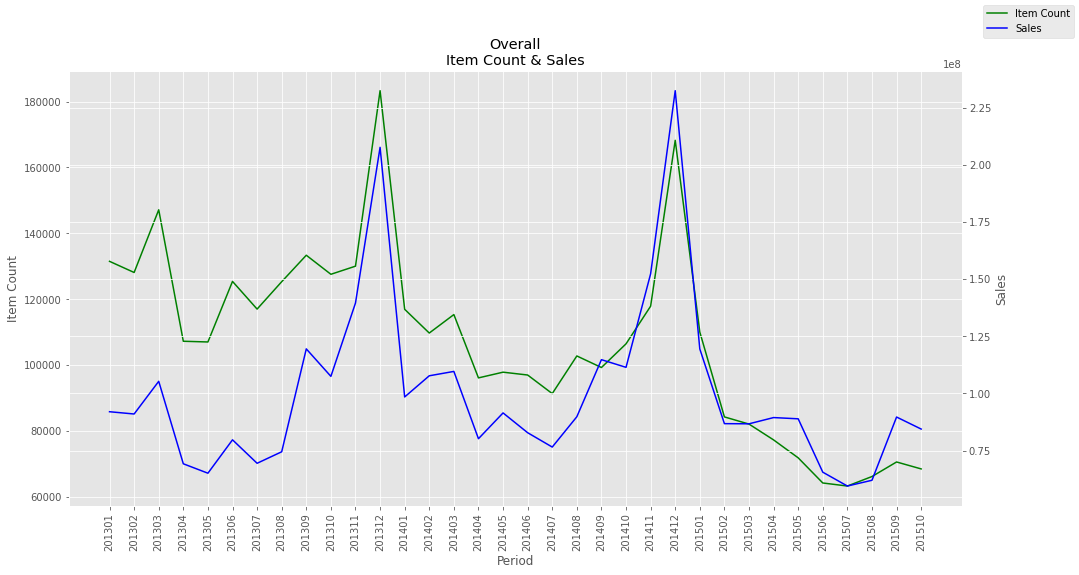

In [5]:
overall = sales.groupby(['year_month'])[['item_cnt_month', 'sales_month']].sum().reset_index()
overall.sort_values(['year_month'], inplace=True)
plot_trends(overall, 'Overall')

## Sales by City

********
АДЫГЕЯ
********

(34, 4)


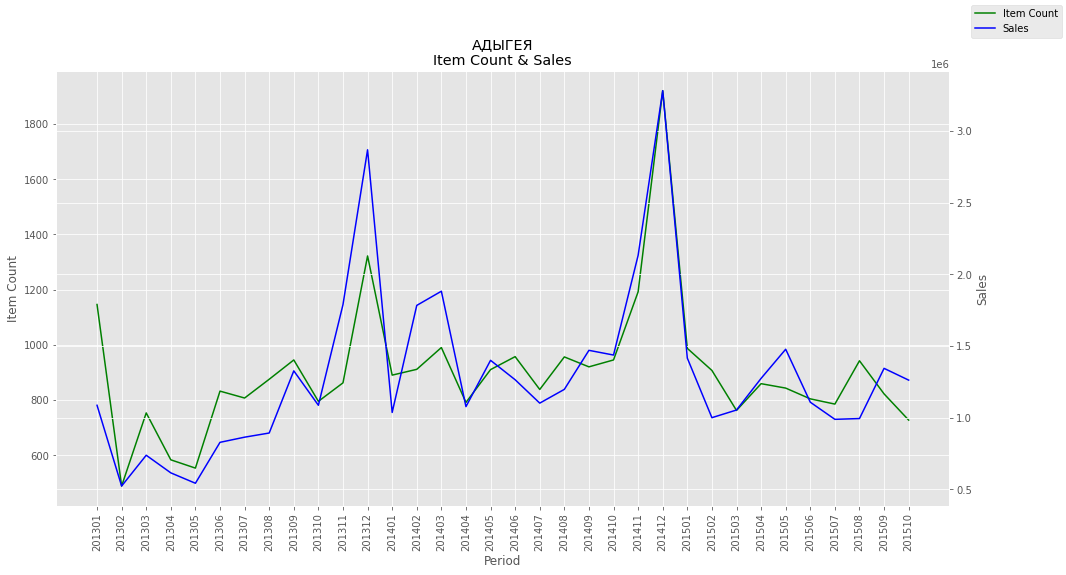

********
БАЛАШИХА
********

(34, 4)


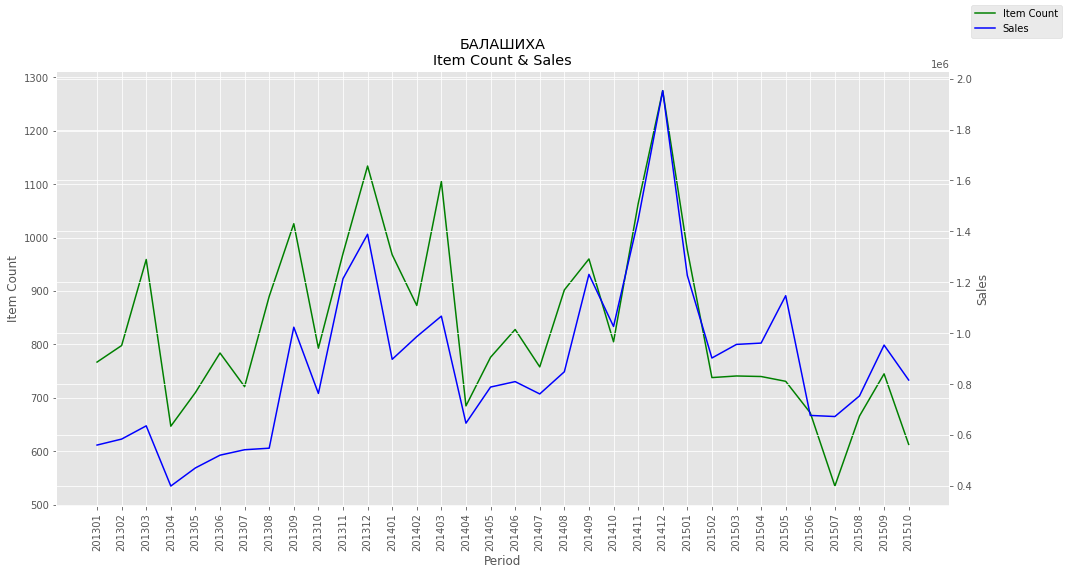

********
ВОЛЖСКИЙ
********

(34, 4)


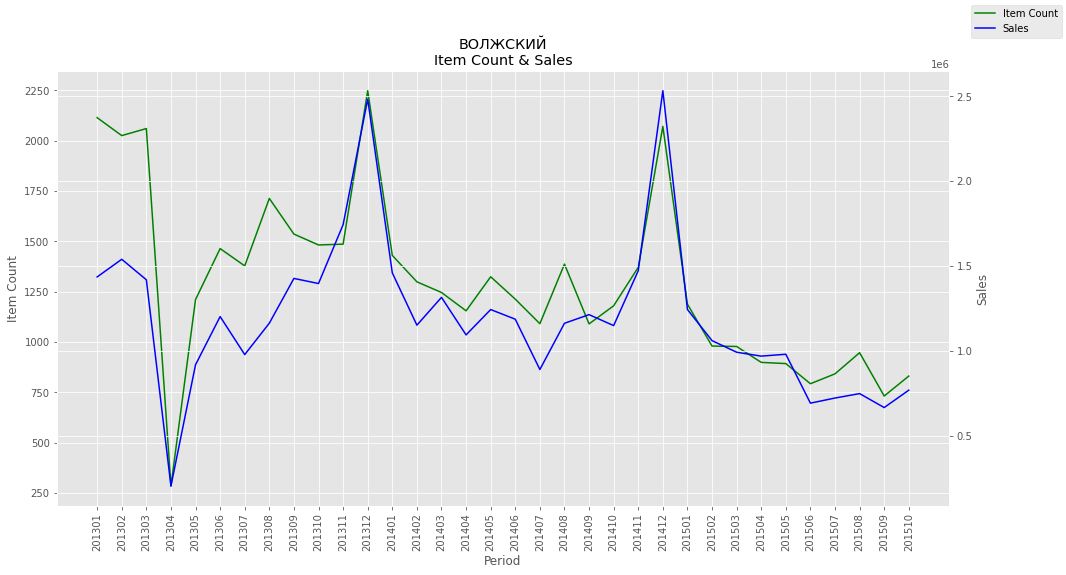

********
ВОЛОГДА
********

(33, 4)


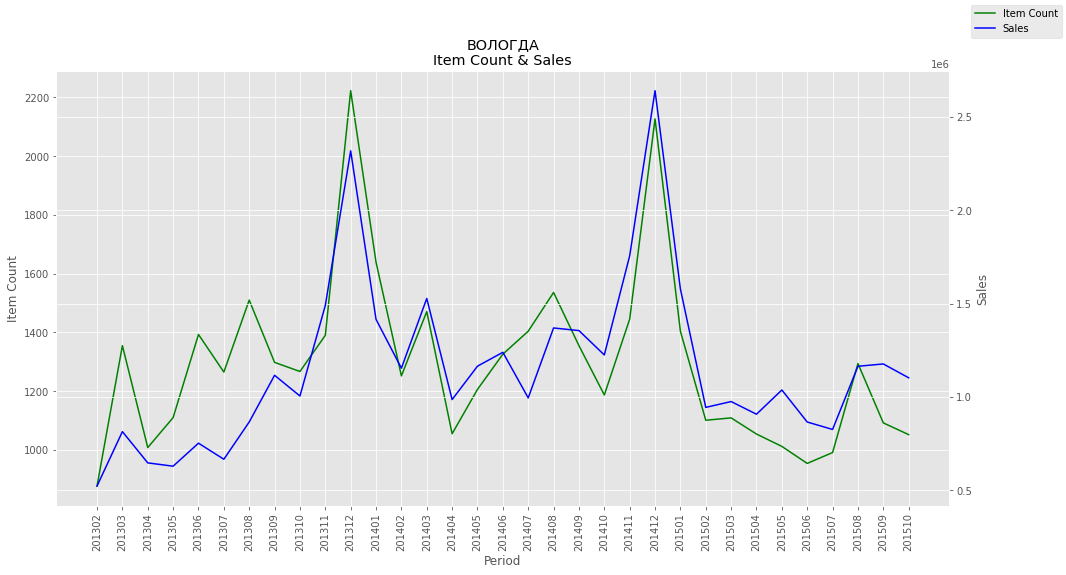

********
ВОРОНЕЖ
********

(34, 4)


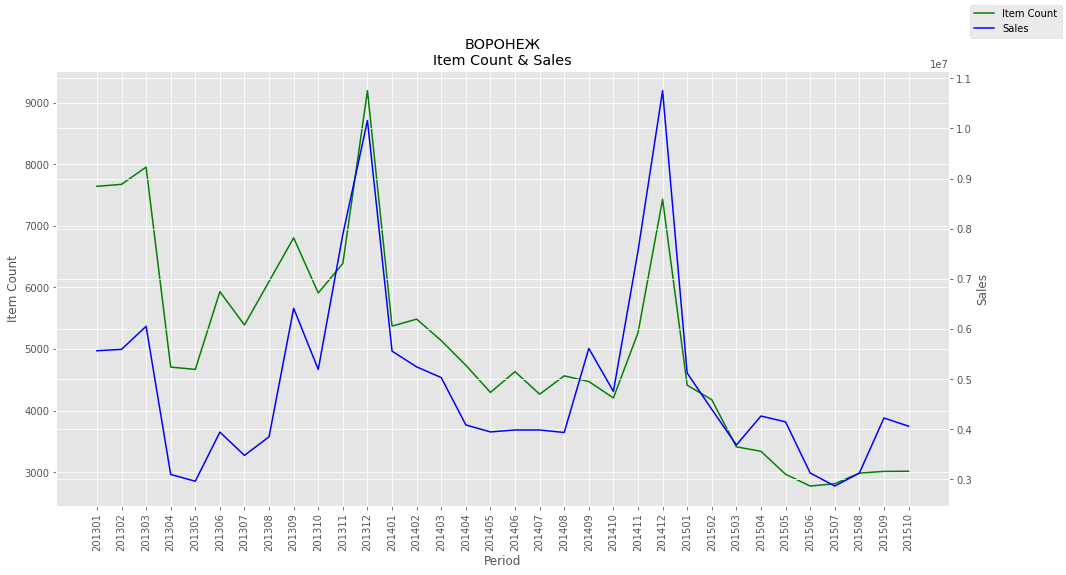

********
ВЫЕЗДНАЯ
********

(4, 4)


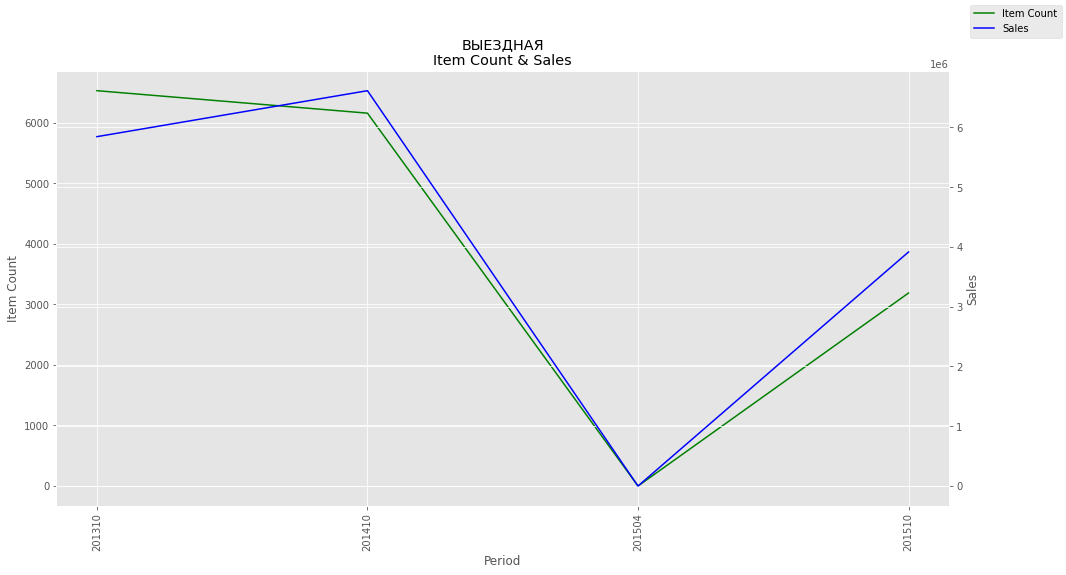

********
ЖУКОВСКИЙ
********

(34, 4)


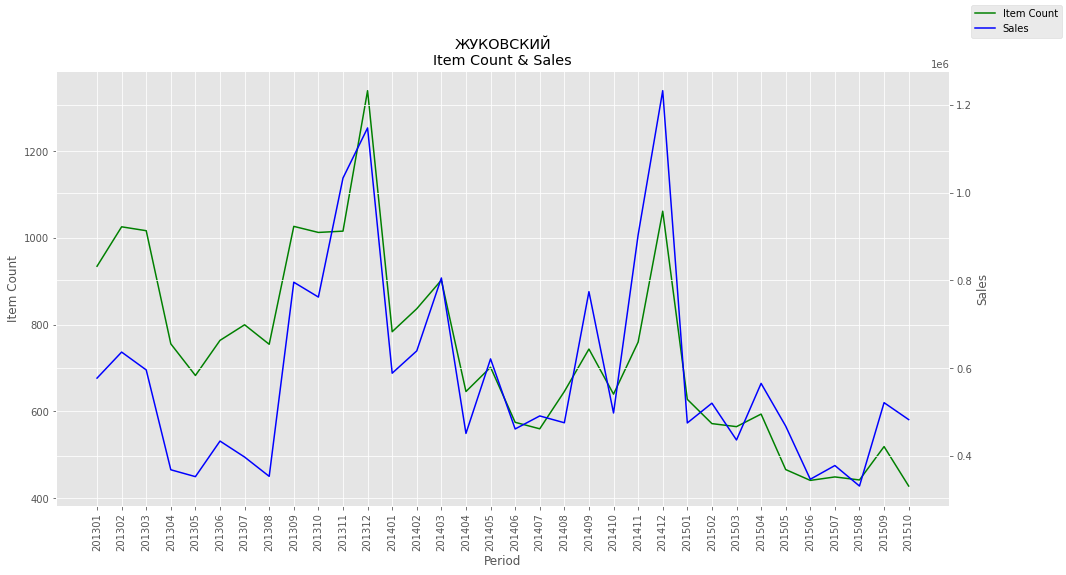

********
ИНТЕРНЕТ-МАГАЗИН
********

(34, 4)


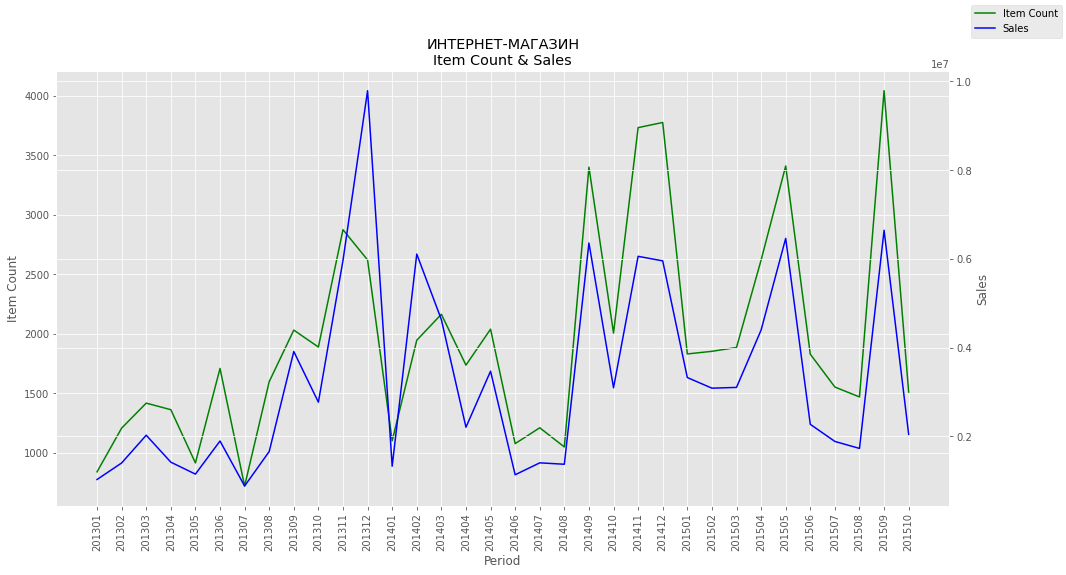

********
КАЗАНЬ
********

(34, 4)


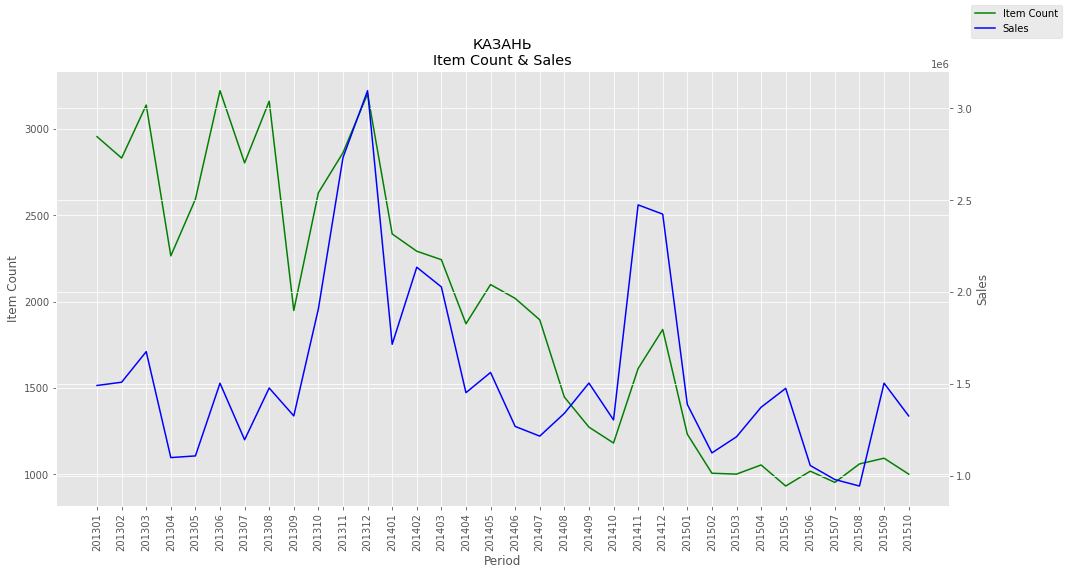

********
КАЛУГА
********

(34, 4)


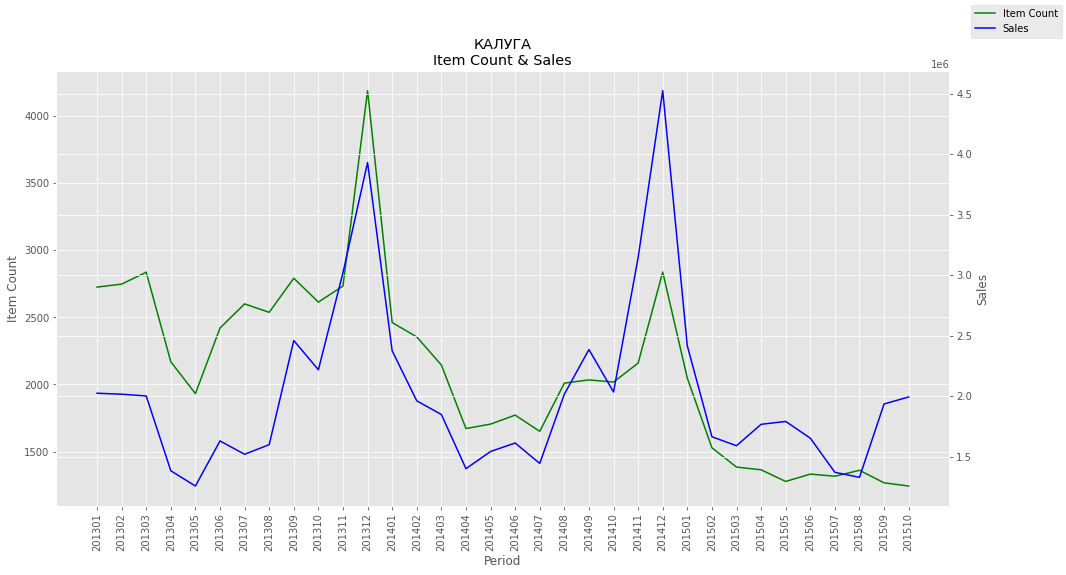

********
КОЛОМНА
********

(34, 4)


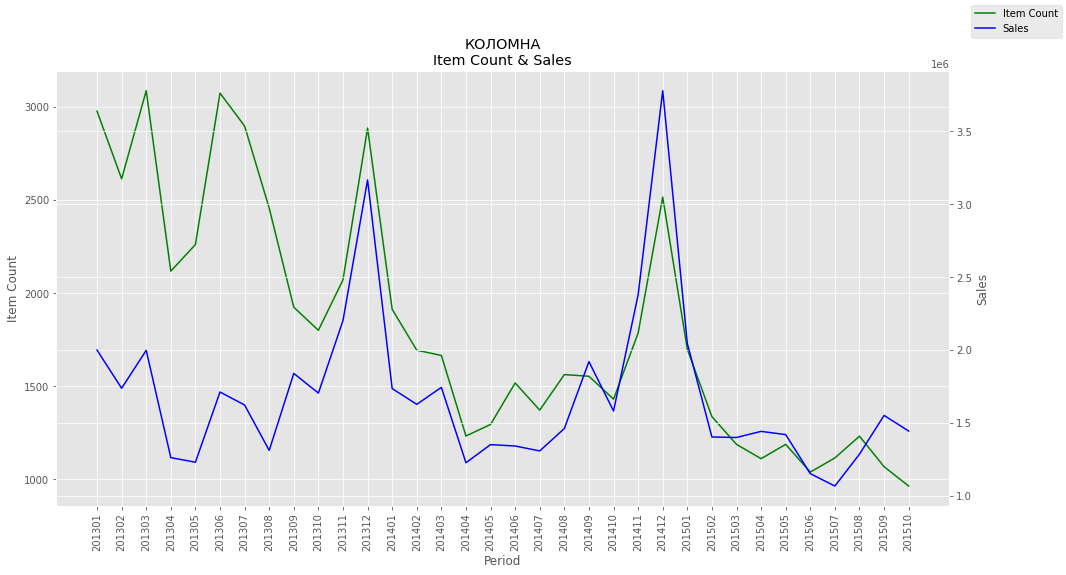

********
КРАСНОЯРСК
********

(34, 4)


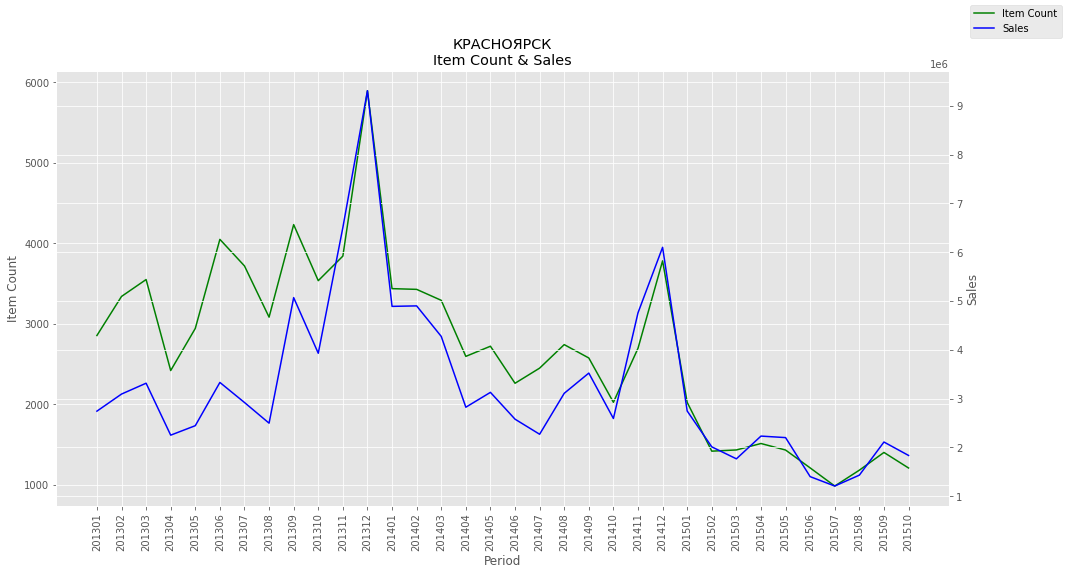

********
КУРСК
********

(34, 4)


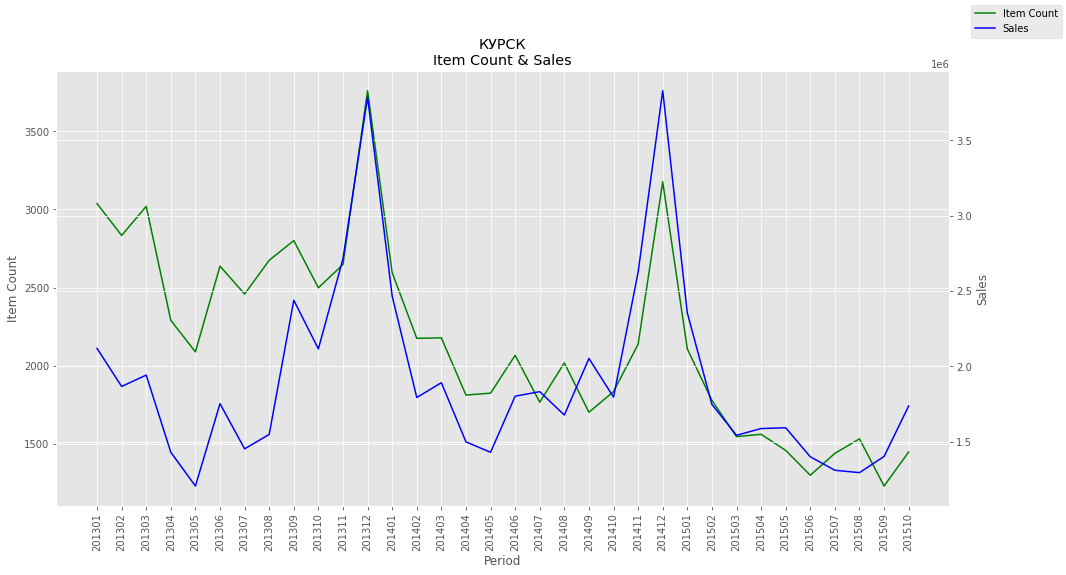

********
МОСКВА
********

(34, 4)


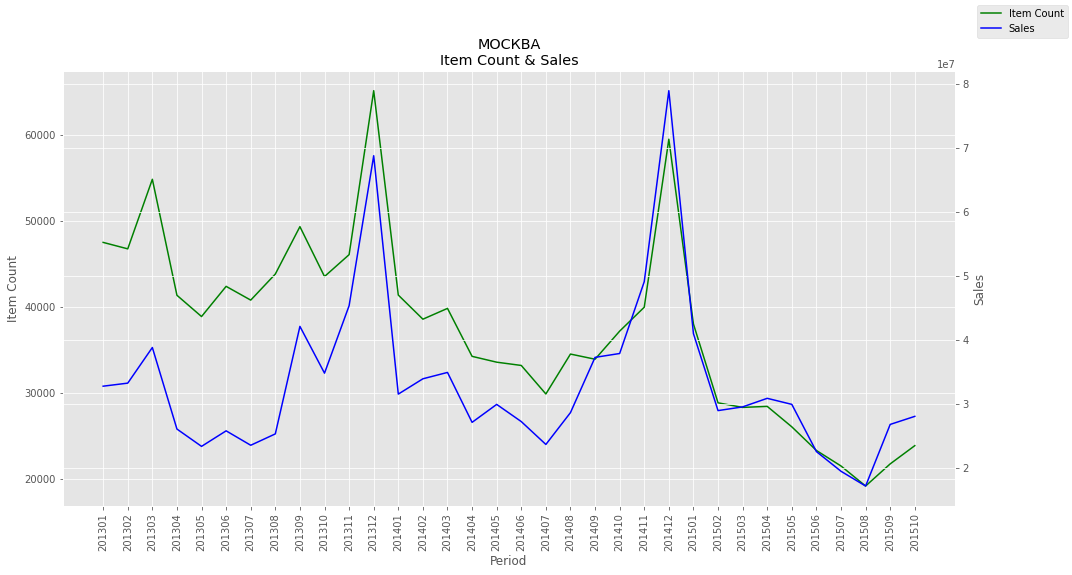

********
МЫТИЩИ
********

(9, 4)


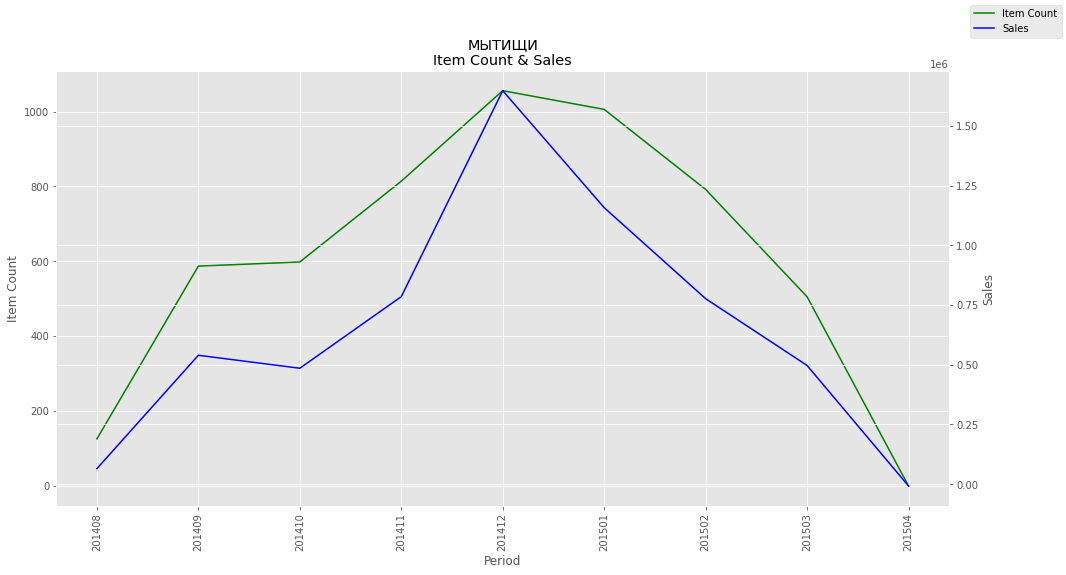

********
ННОВГОРОД
********

(34, 4)


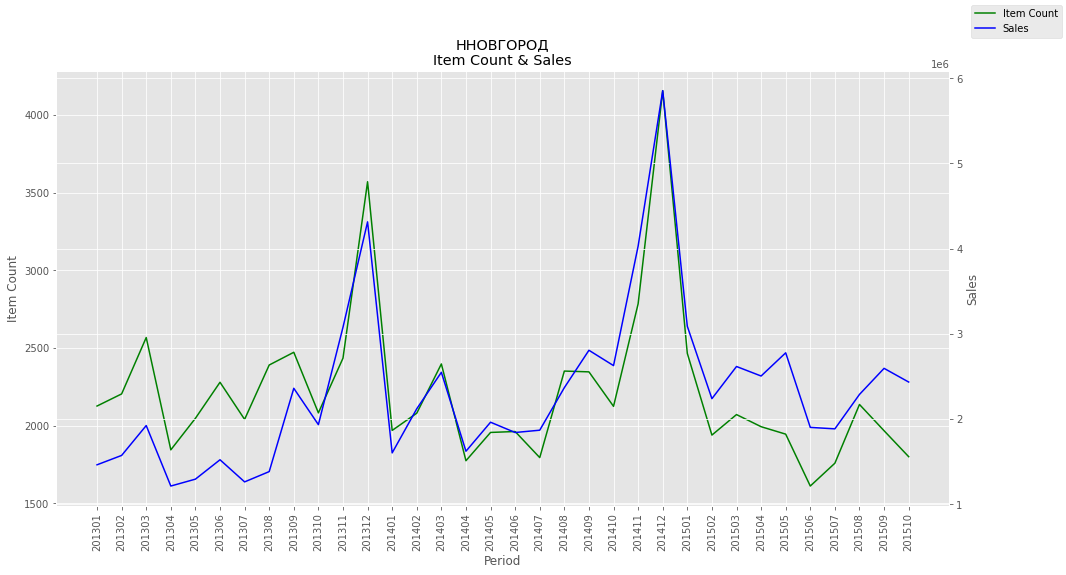

********
НОВОСИБИРСК
********

(34, 4)


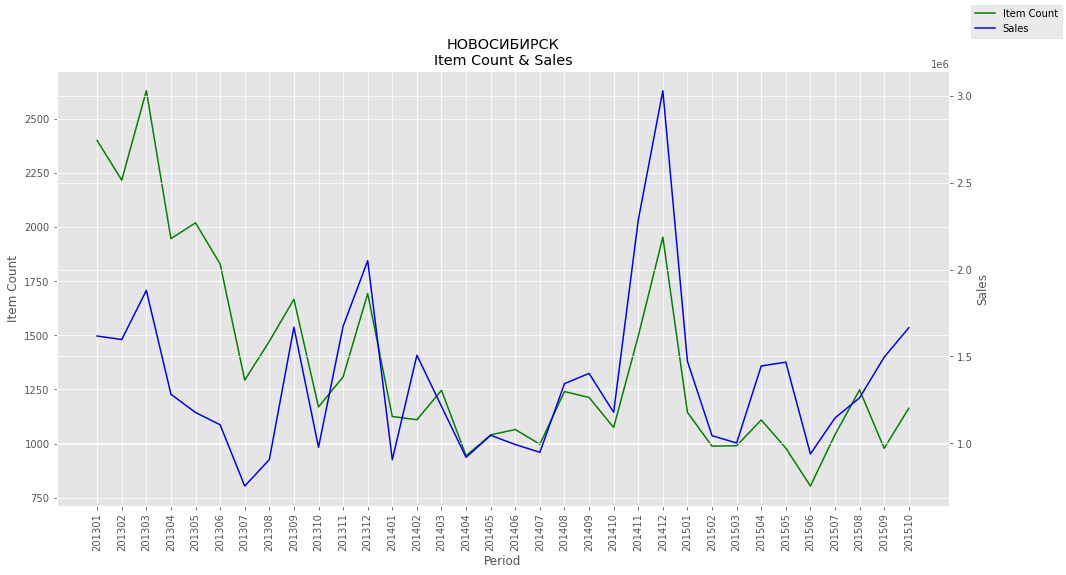

********
ОМСК
********

(34, 4)


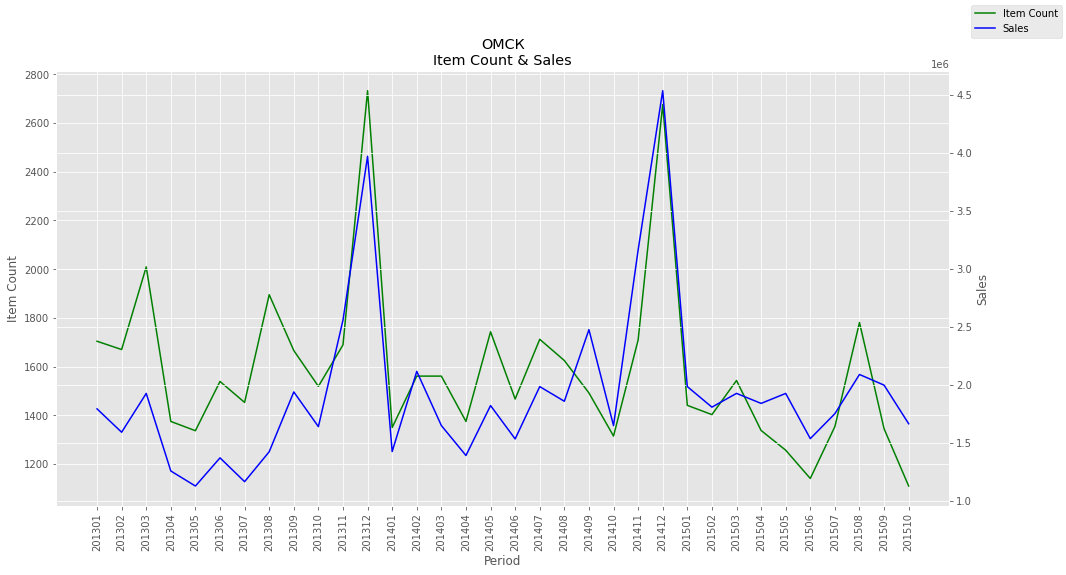

********
РОСТОВНАДОНУ
********

(34, 4)


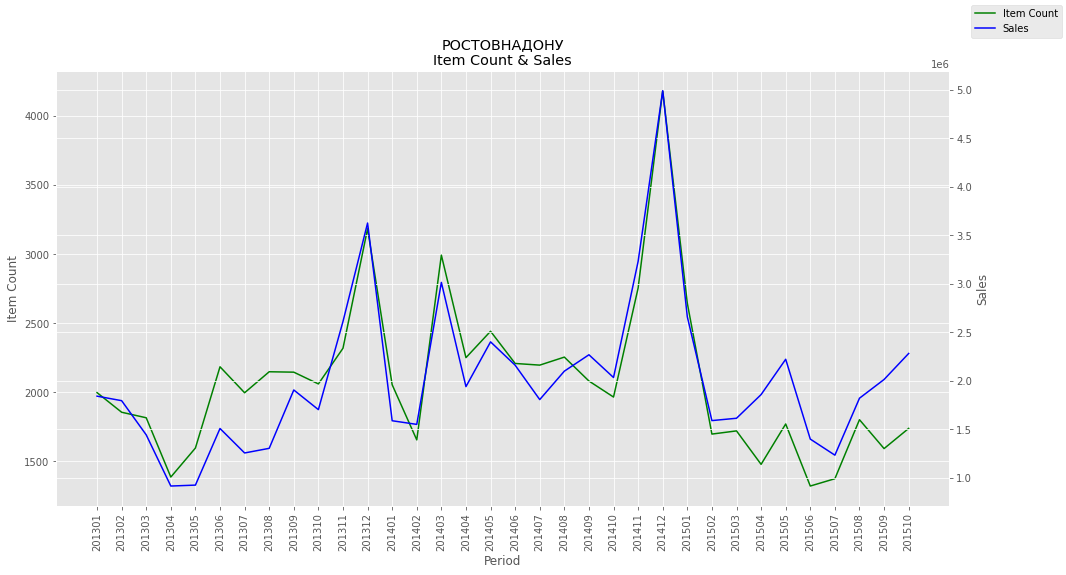

********
САМАРА
********

(34, 4)


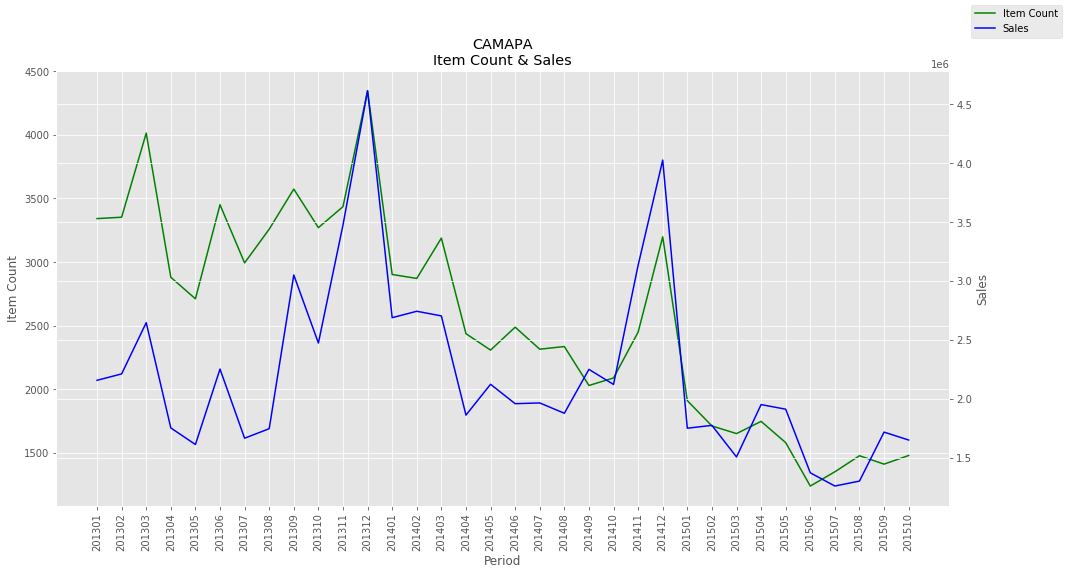

********
СЕРГИЕВ
********

(34, 4)


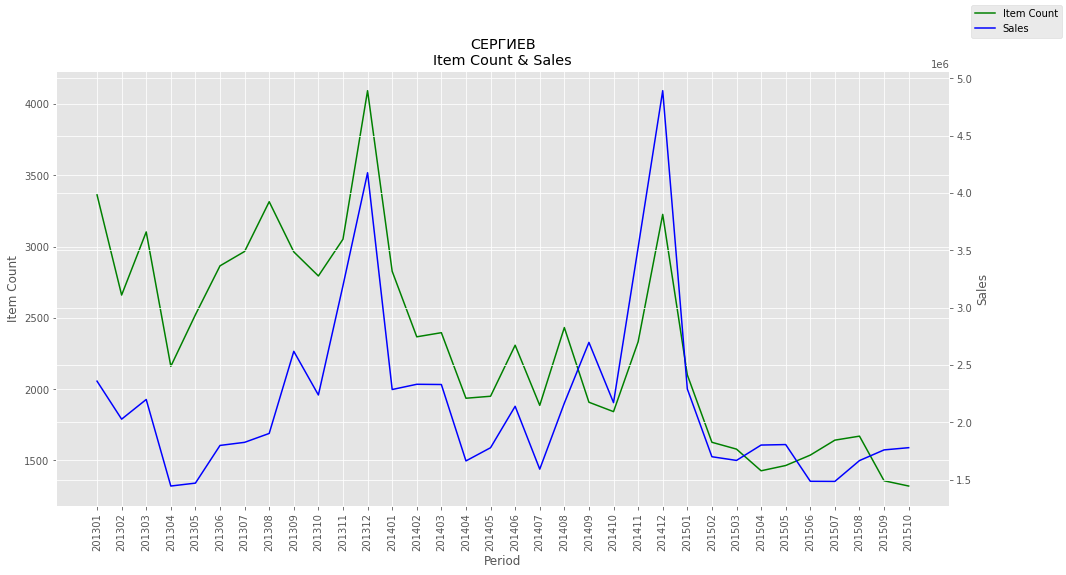

********
СПБ
********

(34, 4)


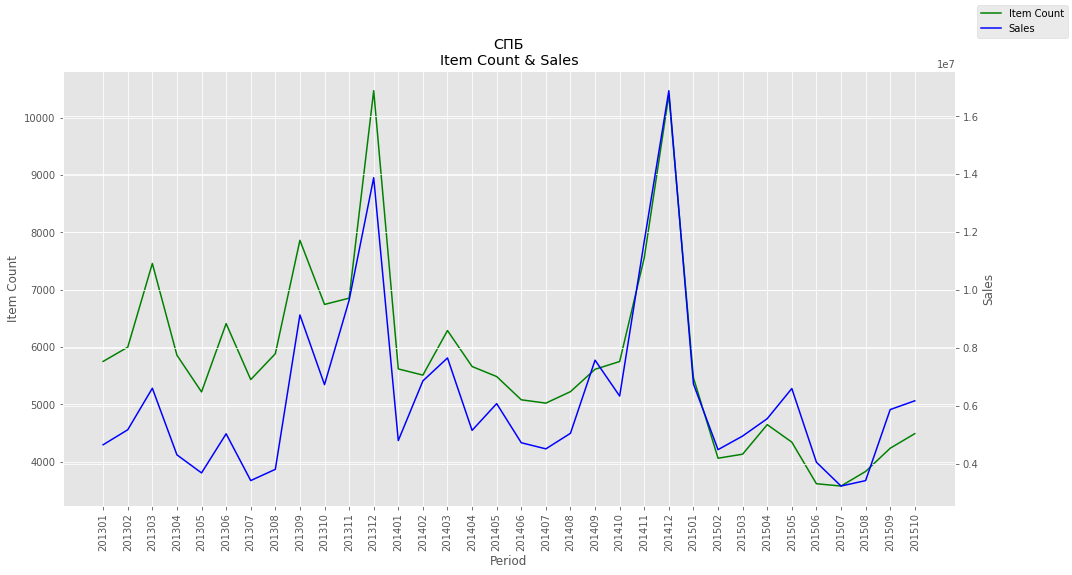

********
СУРГУТ
********

(34, 4)


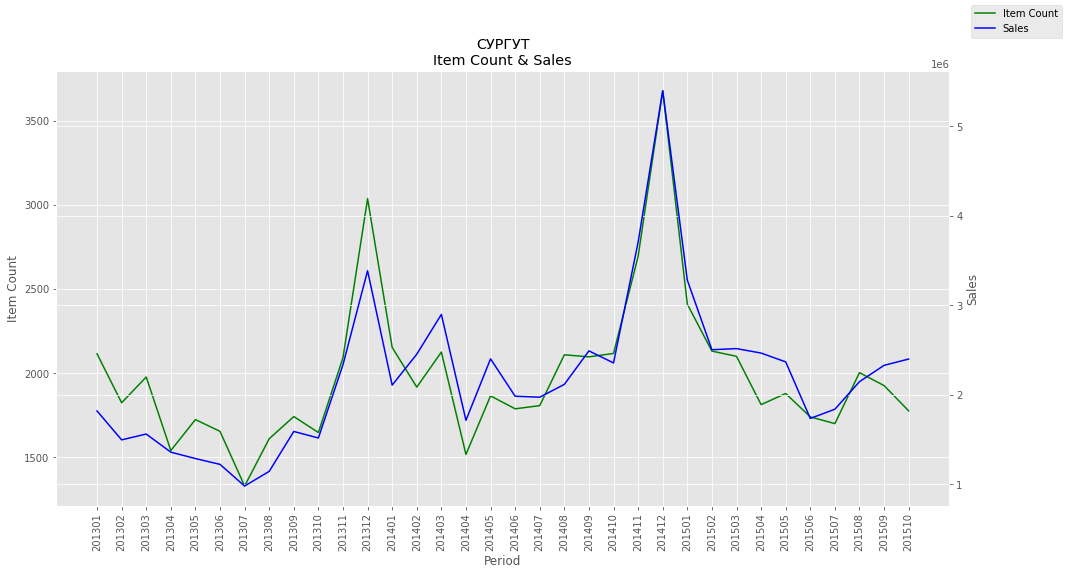

********
ТОМСК
********

(19, 4)


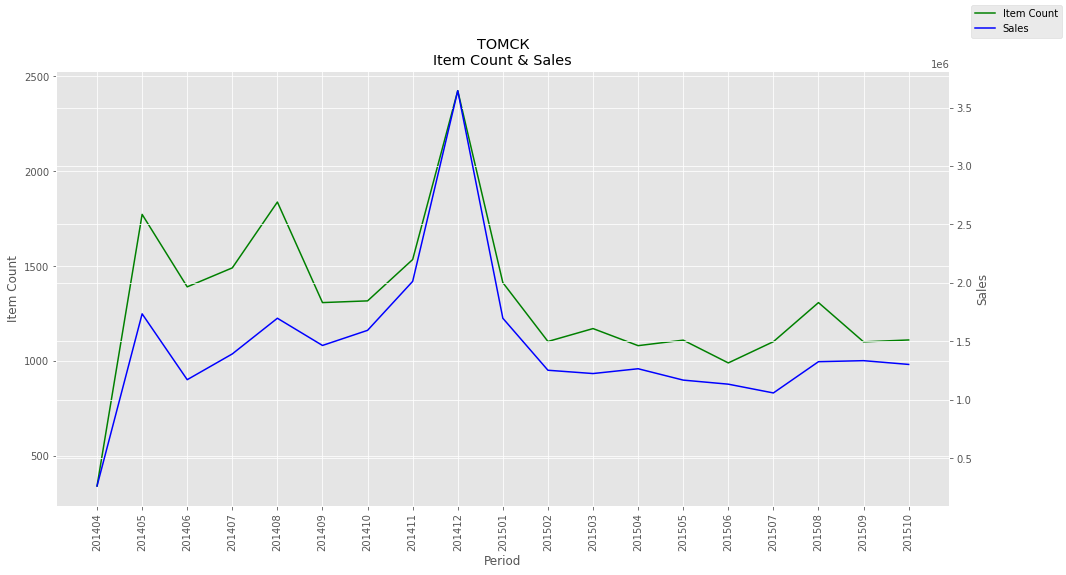

********
ТЮМЕНЬ
********

(34, 4)


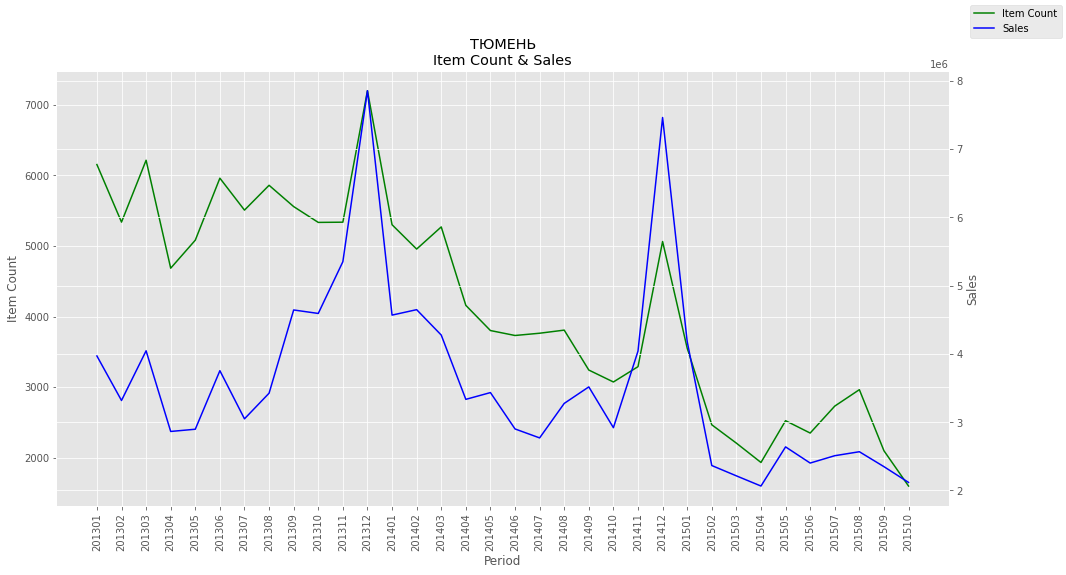

********
УФА
********

(34, 4)


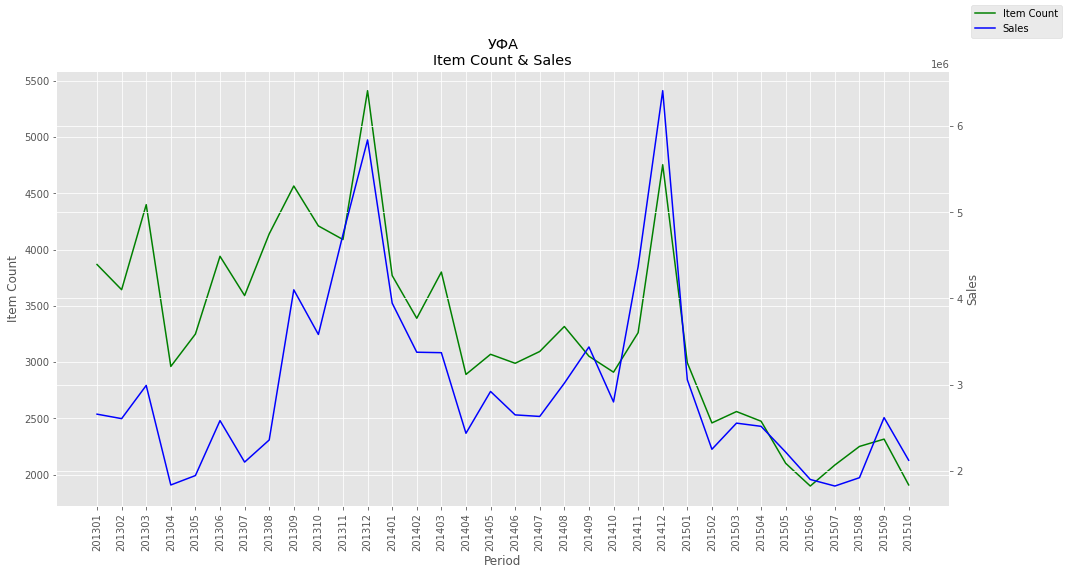

********
ХИМКИ
********

(28, 4)


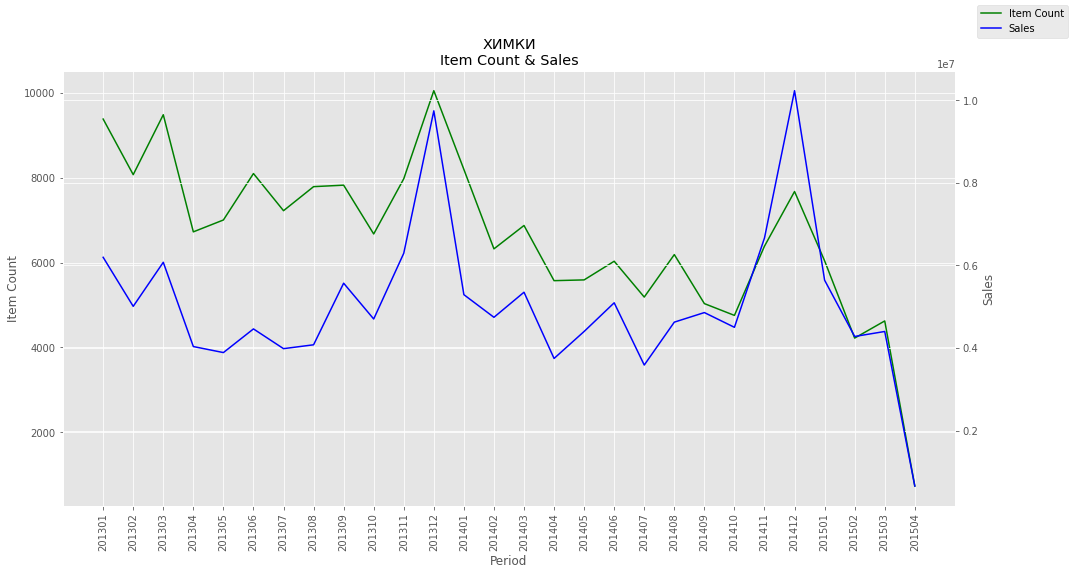

********
ЦИФРОВОЙ
********

(30, 4)


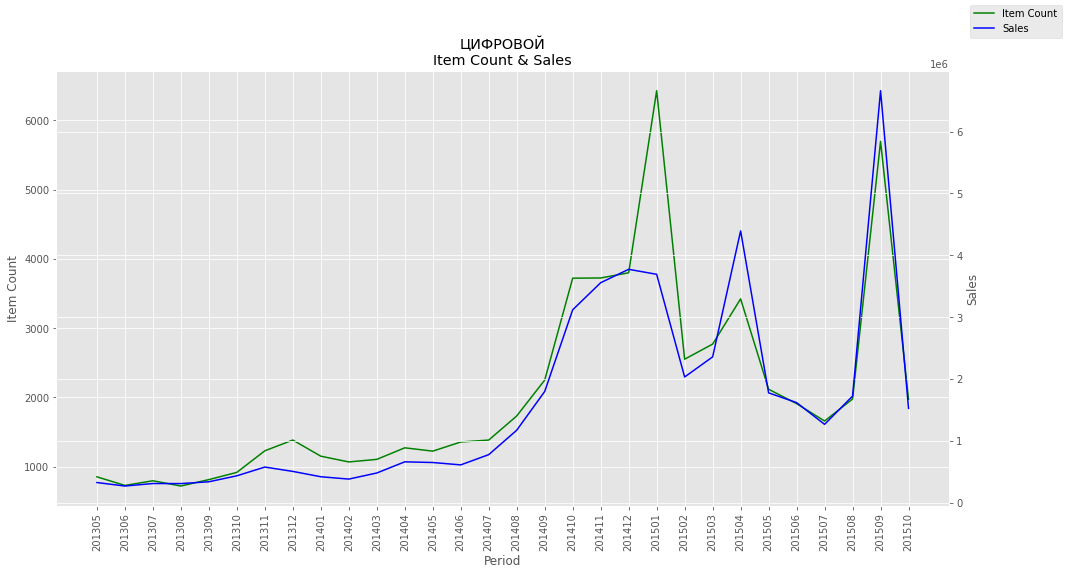

********
ЧЕХОВ
********

(34, 4)


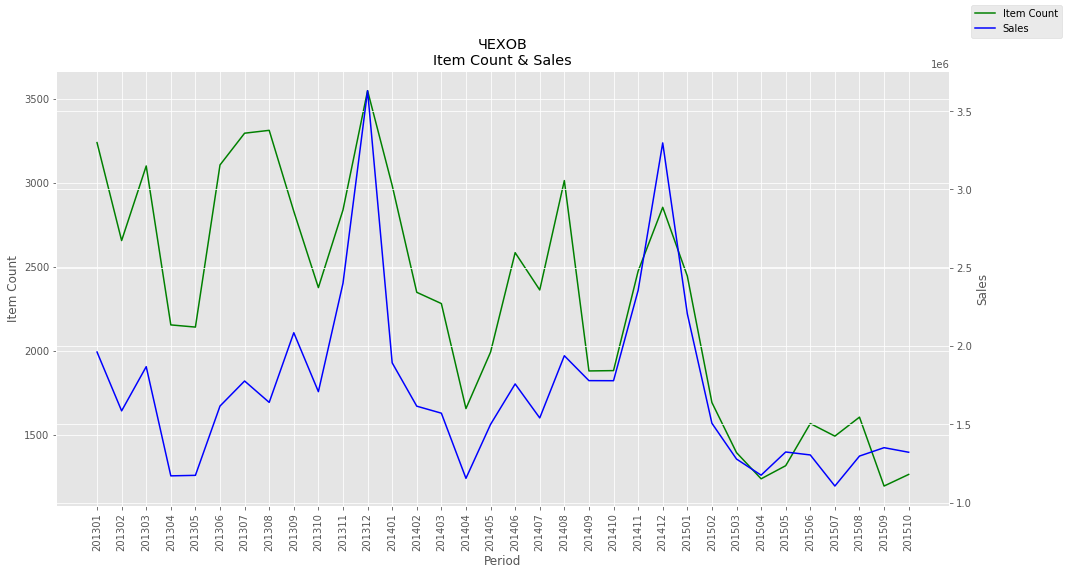

********
ЯКУТСК
********

(34, 4)


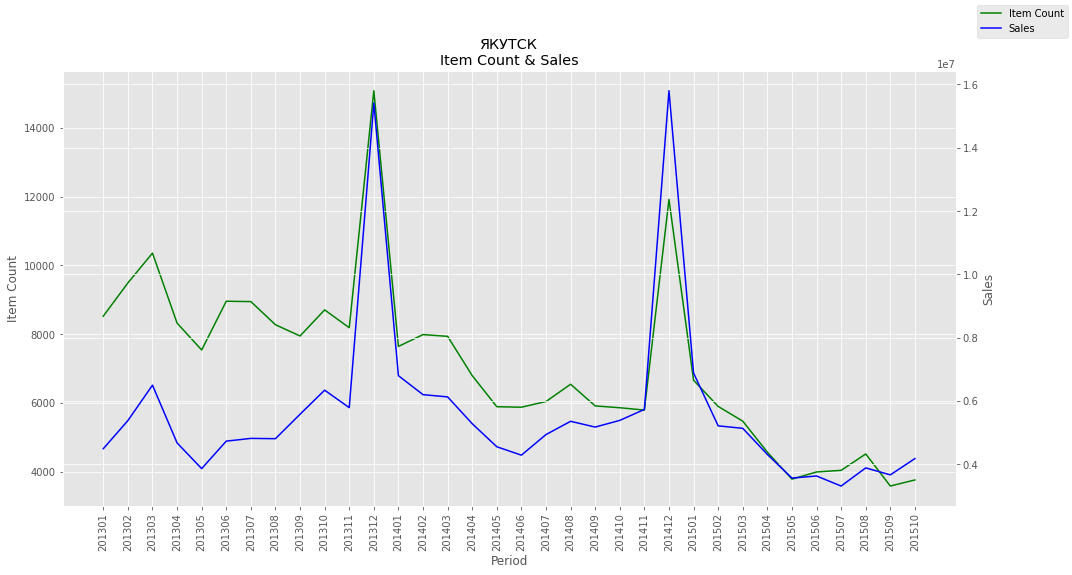

********
ЯРОСЛАВЛЬ
********

(34, 4)


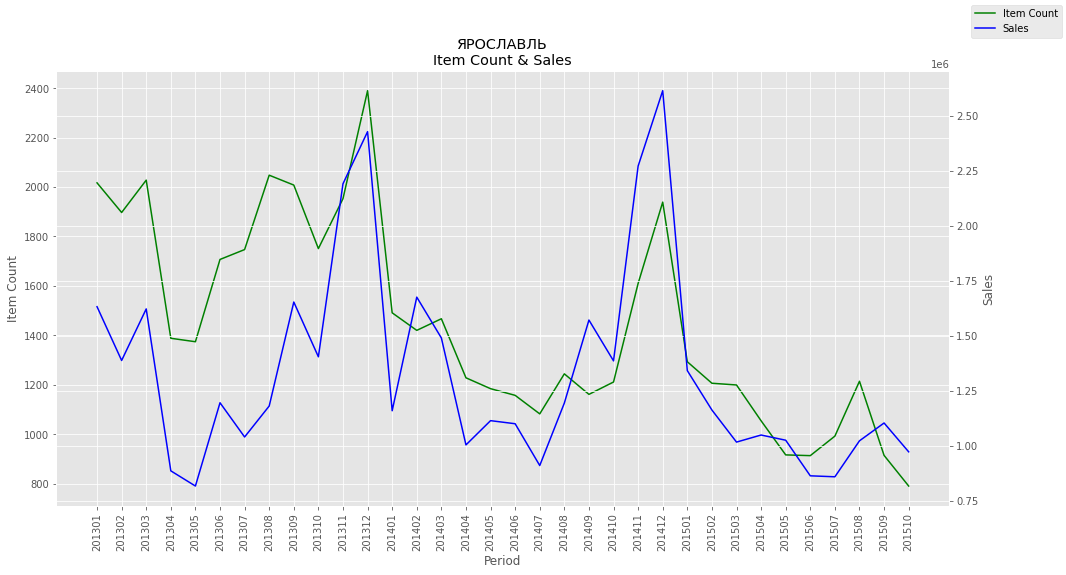

In [8]:
gb_cols = ['loc_name', 'year_month']
city_sales = sales.groupby(gb_cols)[['item_cnt_month', 'sales_month']].sum().reset_index()

for n in sorted(city_sales['loc_name'].unique()):
    print(f'********\n{n}\n********\n')
    subdf = city_sales.loc[city_sales['loc_name'] == n]
    print(subdf.shape)
    plot_trends(subdf, n)

## Sales by the location types

********
тц
********



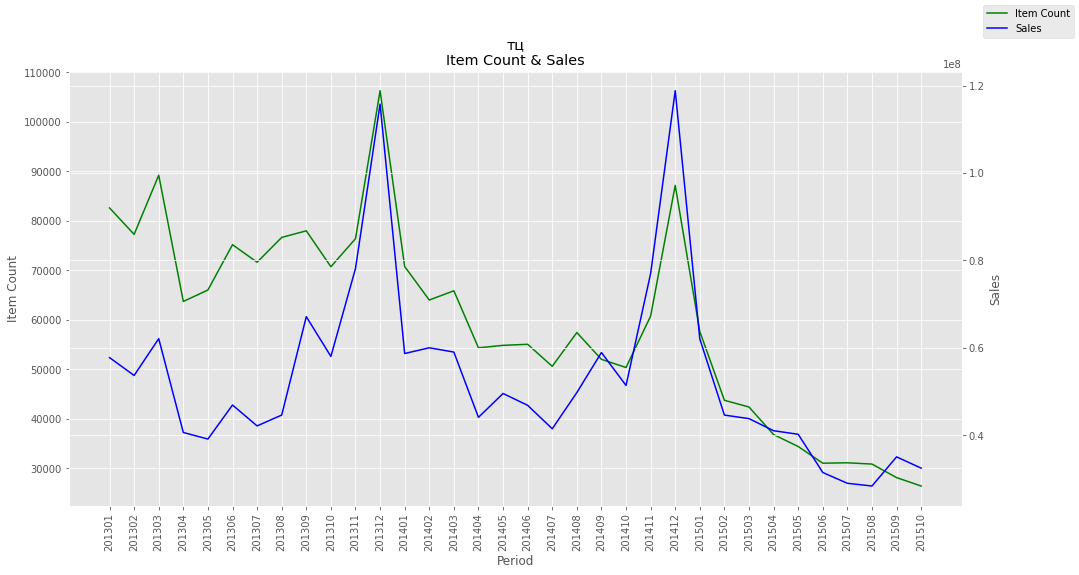

********
трц
********



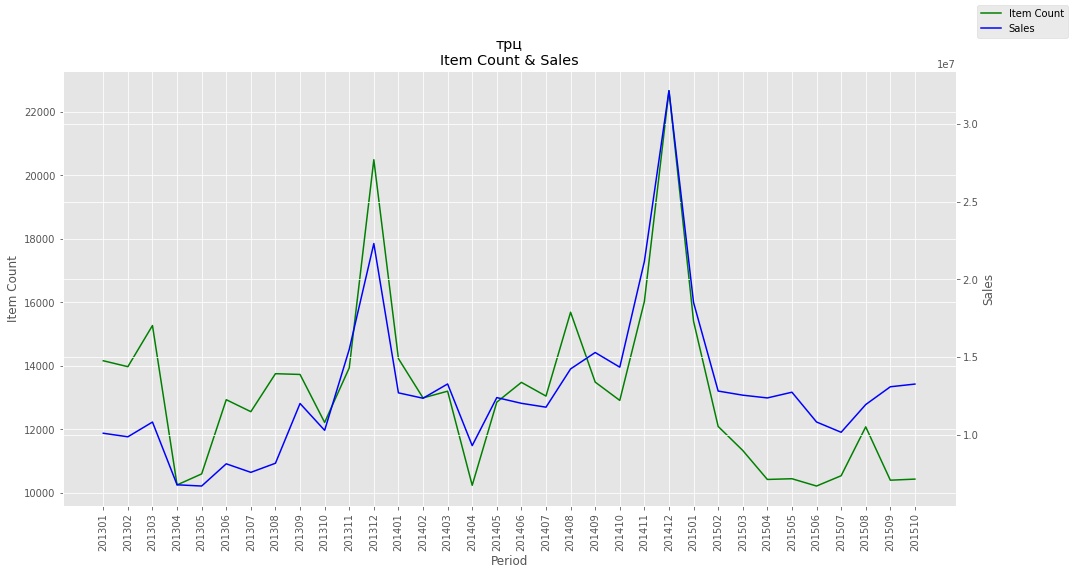

********
мега
********



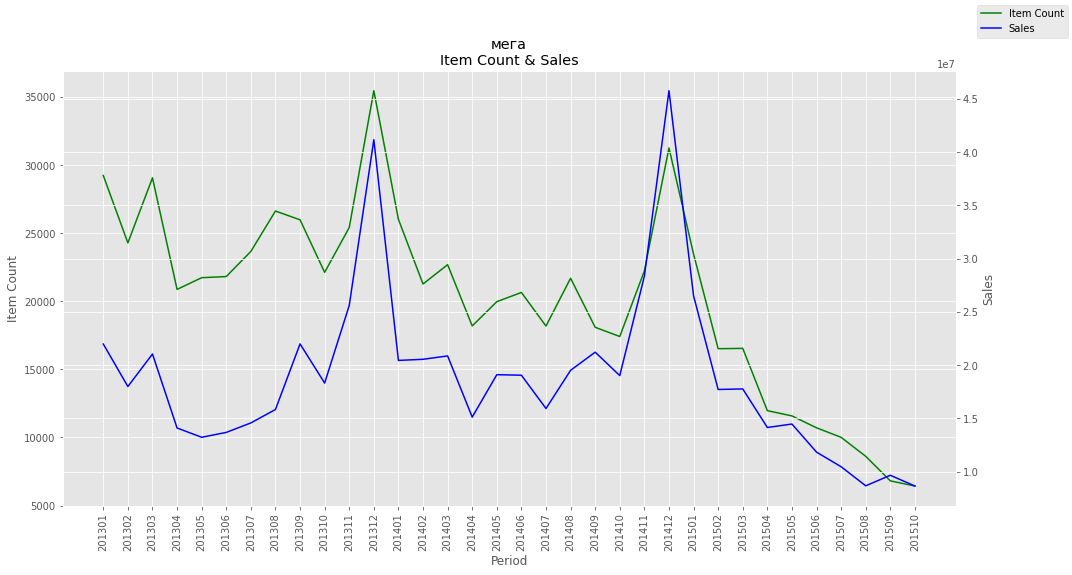

********
тк
********



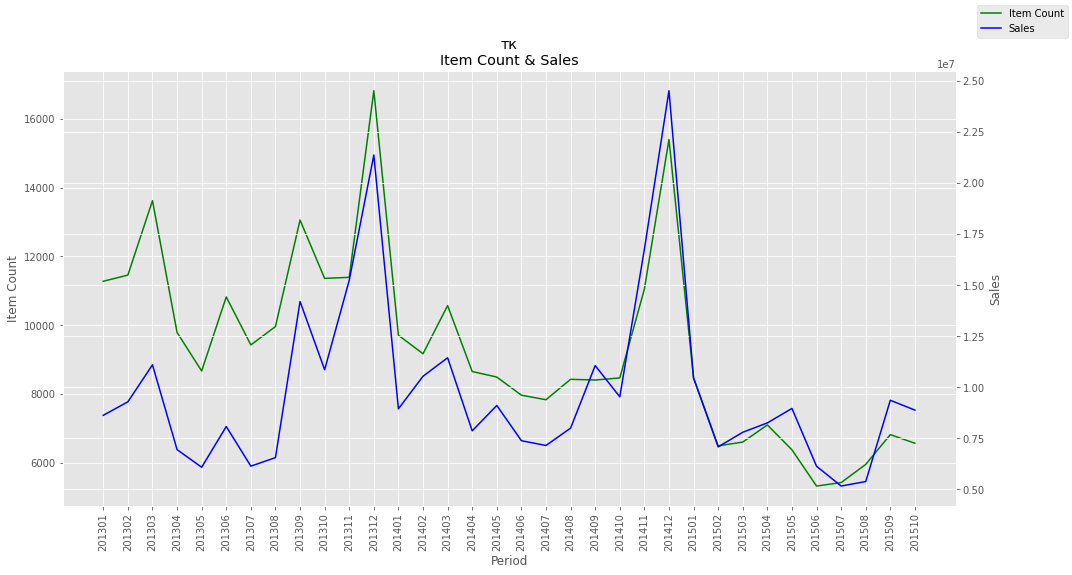

********
трк
********



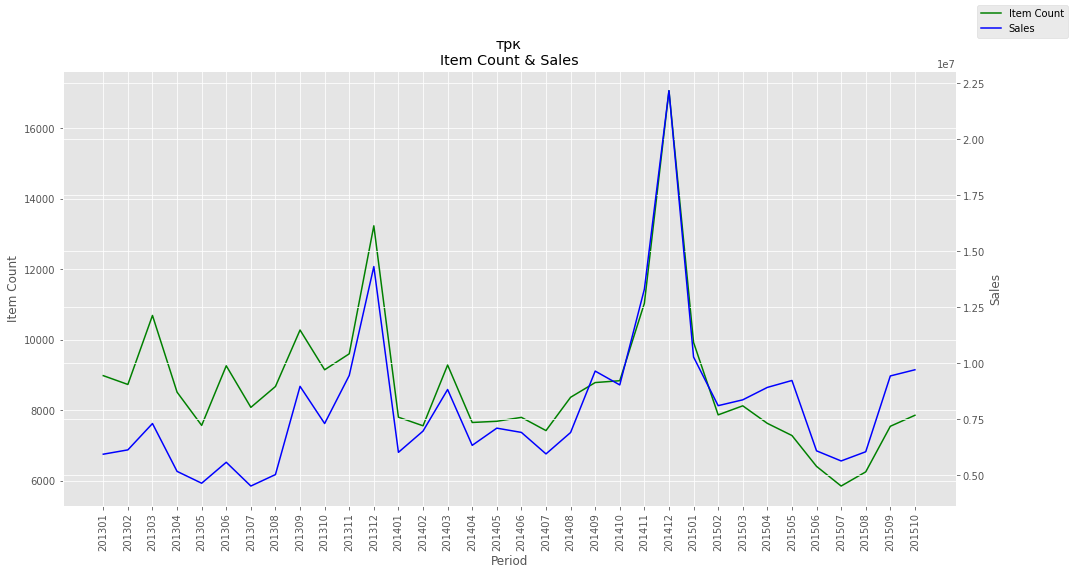

********
молл
********



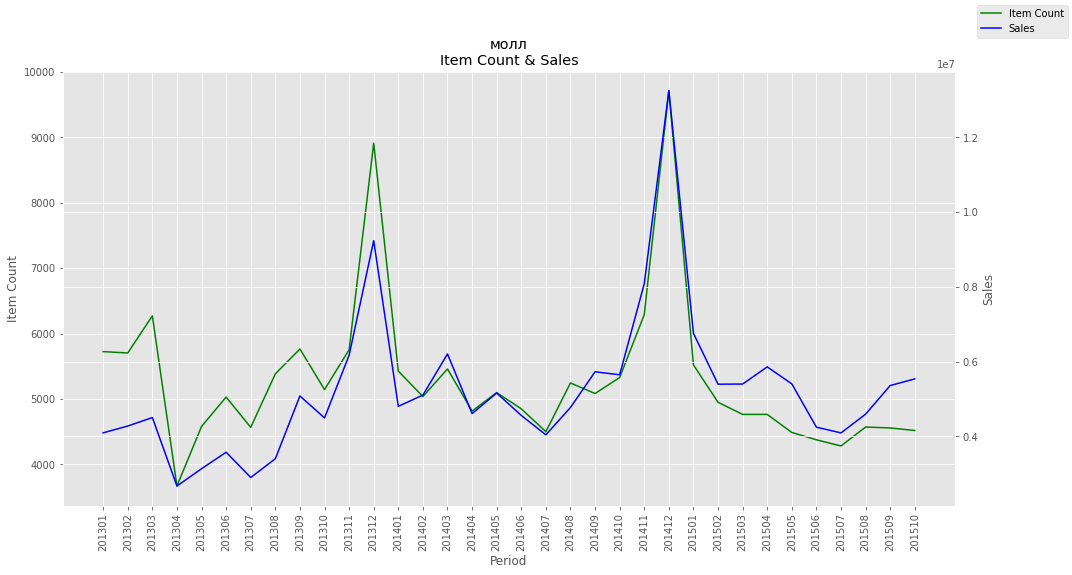

********
центральный
********



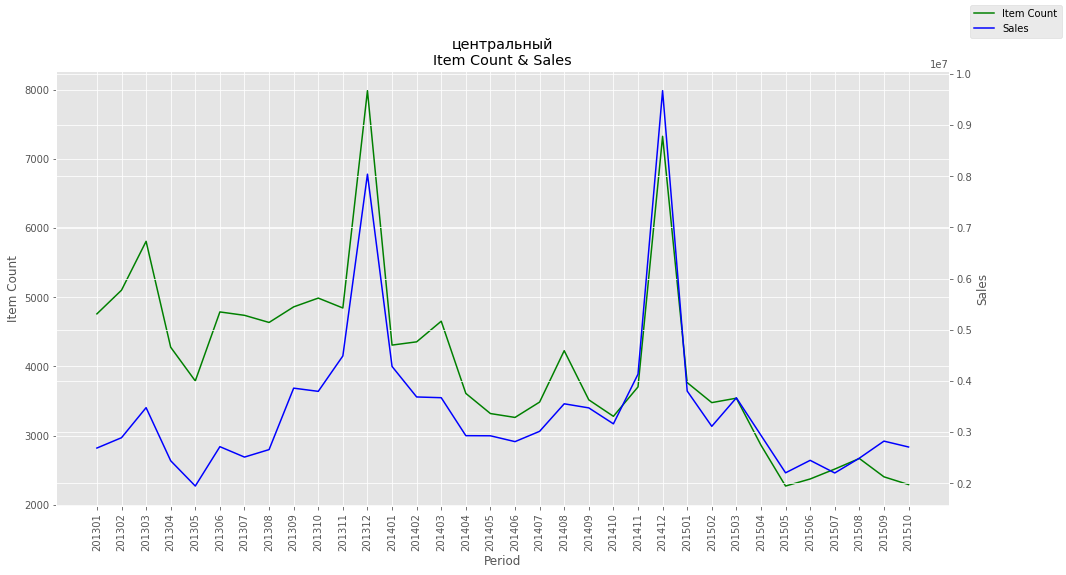

In [9]:
loc_types = ['тц', 'трц', 'мега', 'тк', 'трк', 'молл', 'центральный']

for t in loc_types:
    print(f'********\n{t}\n********\n')
    subdf = sales.loc[sales[t] == 1]
    subdf = subdf.groupby(['year_month'])[['item_cnt_month', 'sales_month']].sum().reset_index()
    plot_trends(subdf, t)

# Focus on a Single Item, Shop

In [14]:
# top_majorcat = 'Игры'
top_loc = 'МОСКВА'
top_loc_type = 'тц'
top_shop_id = '31'
top_cat = 'Игры - XBOX 360'
top_item_id = '4870'

# majorcat_mask = sales['major_category'] == top_majorcat
loc_mask = sales['loc_name'] == top_loc
shop_mask = sales['shop_id'] == top_shop_id
cat_mask = sales['item_category_name'] == top_cat
item_mask = sales['item_id'] == top_item_id

top_item = sales.loc[
#                        majorcat_mask & 
                       loc_mask & 
                       shop_mask & 
                       cat_mask &
                       item_mask &
                       (sales[top_loc_type] == 1)]
top_item.head()

,date_block_num,year,month,year_month,shop_id,item_id,item_cnt_month,avg_price,sales_month,loc_name,тц,трц,мега,тк,трк,молл,центральный,item_name,item_category_id,item_category_name
757137,6,2013,07,201307,31,4870,19.0,799.0,15181.0,МОСКВА,1,0,0,0,0,0,0,"Minecraft [Xbox 360, английская версия]",23,Игры - XBOX 360
757138,7,2013,08,201308,31,4870,21.0,799.0,16779.0,МОСКВА,1,0,0,0,0,0,0,"Minecraft [Xbox 360, английская версия]",23,Игры - XBOX 360
757139,8,2013,09,201309,31,4870,19.0,799.0,15181.0,МОСКВА,1,0,0,0,0,0,0,"Minecraft [Xbox 360, английская версия]",23,Игры - XBOX 360
757140,9,2013,10,201310,31,4870,23.0,799.0,18377.0,МОСКВА,1,0,0,0,0,0,0,"Minecraft [Xbox 360, английская версия]",23,Игры - XBOX 360
757141,10,2013,11,201311,31,4870,14.0,799.0,11186.0,МОСКВА,1,0,0,0,0,0,0,"Minecraft [Xbox 360, английская версия]",23,Игры - XBOX 360


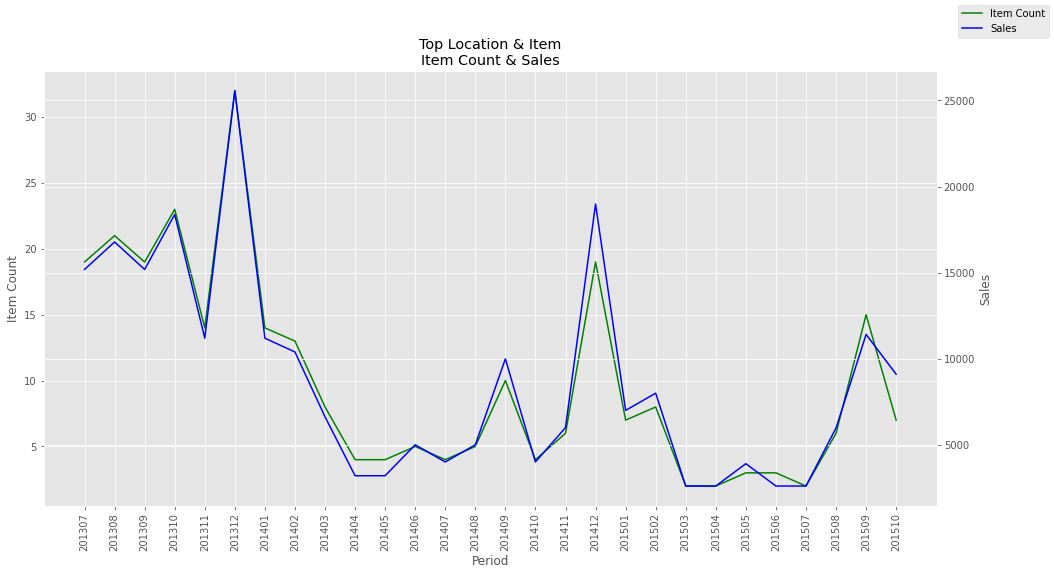

In [15]:
plot_trends(top_item, 'Top Location & Item')

### Item Counts in Top Category

In [16]:
top_cat = sales.loc[
#                        majorcat_mask & 
                       loc_mask & 
                       shop_mask & 
                       cat_mask &
#                        item_mask &
                       (sales[top_loc_type] == 1)]

In [17]:
top_cat.groupby('item_id')['item_cnt_month'] \
    .sum().reset_index().sort_values('item_cnt_month', ascending=False).head(20)

,item_id,item_cnt_month
183,3734,663.0
148,3343,284.0
236,4870,279.0
146,3335,215.0
209,4244,181.0
212,4249,172.0
145,3328,161.0
136,3077,161.0
173,3556,138.0
179,3676,133.0


## Focus on a single shop/item

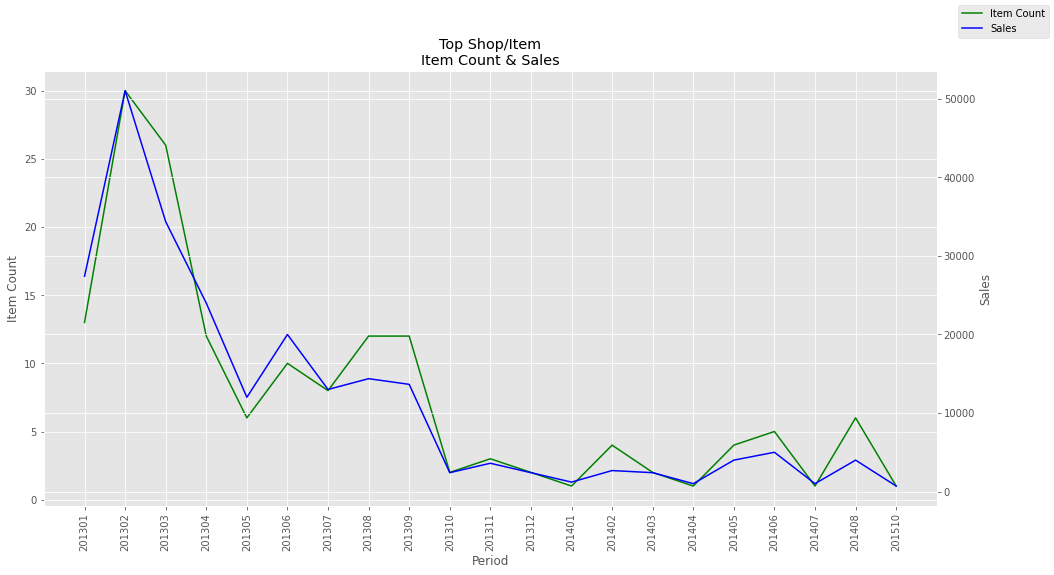

In [18]:
top_shop_id = '31'
top_item_id = '3328'

top_item = sales.loc[(sales['shop_id'] == top_shop_id) & 
                    (sales['item_id'] == top_item_id)].copy()

plot_trends(top_item, 'Top Shop/Item')

## Decompose

In [19]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [20]:
# format plot_date as datetime
top_item['plot_date'] = top_item['month'].astype(str) + '-' + top_item['year'].astype(str)
top_item['plot_date'] = top_item['plot_date'].apply(lambda x: datetime.strptime(x, '%m-%Y'))

topitem_trend = top_item.loc[:, ['plot_date', 'item_cnt_month']].copy()
topitem_trend = topitem_trend.set_index('plot_date')

In [21]:
topitem_trend = sd.add_missing_periods(topitem_trend)

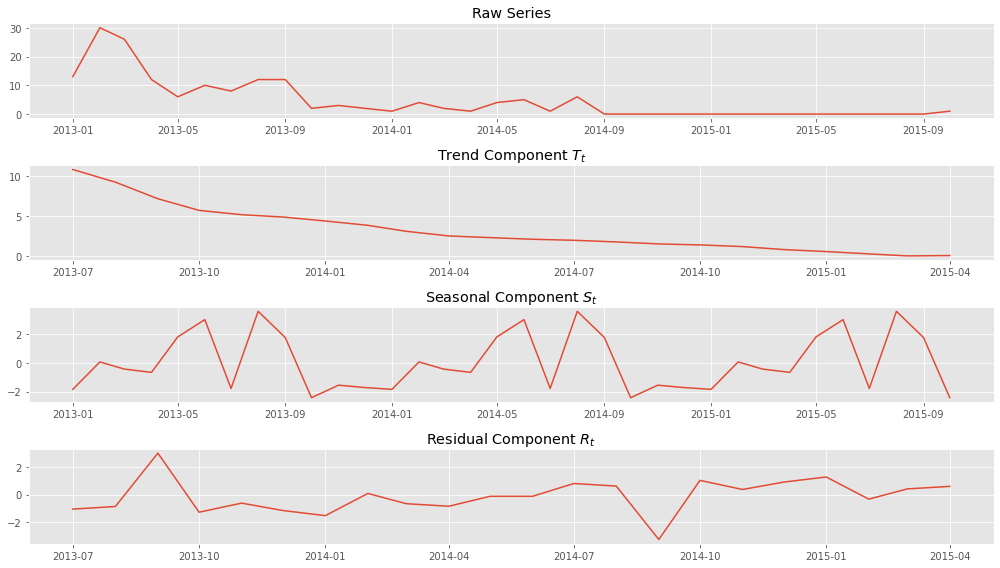

In [22]:
python_decomposition = sm.tsa.seasonal_decompose(topitem_trend)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, topitem_trend, python_decomposition)
plt.tight_layout()

### Test for Stationarity

In [23]:
test = sm.tsa.stattools.adfuller(topitem_trend)
print(f'ADF p-value for topitem_trend: {np.round(test[1], 2)}')

ADF p-value for topitem_trend: 0.15


In [24]:
topitem_diff = topitem_trend.diff()[1:]
test = sm.tsa.stattools.adfuller(topitem_diff)
print(f'ADF p-value for topitem_trend: {np.round(test[1], 2)}')

ADF p-value for topitem_trend: 0.0


The differenced series is stationary.

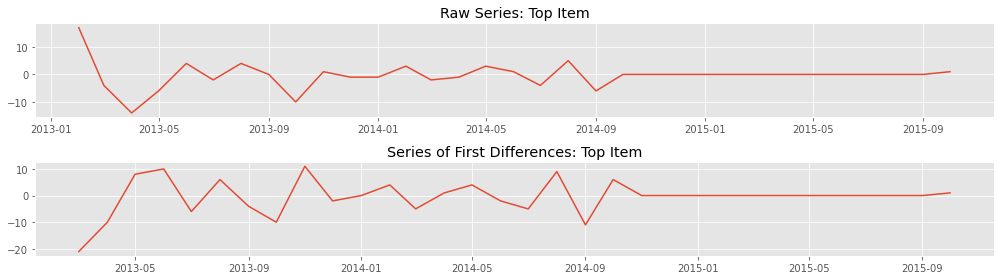

In [25]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, topitem_diff, 'Top Item')
fig.tight_layout()

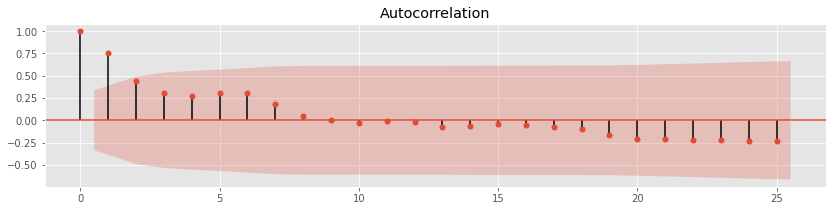

In [26]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(topitem_trend, lags=25, ax=ax)

/Users/u1b1700/.pyenv/versions/3.7.7/envs/kag/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


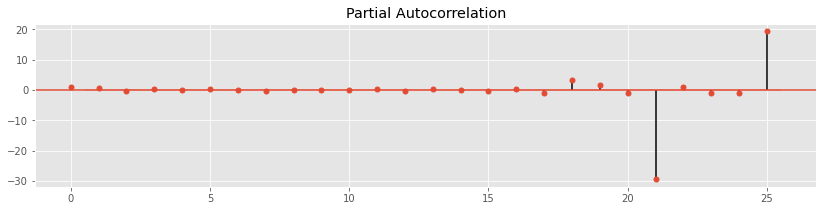

In [27]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(topitem_trend, lags=25, ax=ax)

In [28]:
topitem_model = ARIMA(topitem_trend, order=(2, 1, 0)).fit()

/Users/u1b1700/.pyenv/versions/3.7.7/envs/kag/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/u1b1700/.pyenv/versions/3.7.7/envs/kag/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [29]:
print("ARIMA(3, 1, 0) coefficients from Top Item model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    topitem_model.params[0], 
        format_list_of_floats(list(topitem_model.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Top Item model:
  Intercept -0.56
  AR ['-0.10', '-0.55']


## Predict

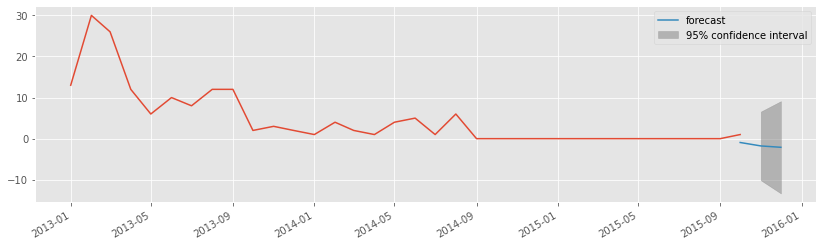

In [30]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(topitem_trend)
fig = topitem_model.plot_predict(start='2015-10-01', end='2015-12-01', 
                                 dynamic=True, ax=ax, plot_insample=False)

Not enough points to fit an ARIMA model properly?

# Regressions
Look at both linear and polynomial regressions...

In [ ]:
l = [
    {'ID': 0, 'item_cnt_month': 0.1},
    {'ID': 1, 'item_cnt_month': 0.2},
    {'ID': 2, 'item_cnt_month': 0.3},
    {'ID': 3, 'item_cnt_month': 0.4},
]

pd.DataFrame.from_records(l)

In [ ]:
topitem_trend.tail()

In [ ]:
# X = np.arange(topitem_trend.shape[0] - 1).reshape(-1, 1)
X = topitem_trend.index
y = topitem_trend.iloc[:, 0]
# plt.plot(X, y)

mr = MultiReg(poly_degree=2)
mr.fit(X, y)
y_pred = mr.predict_next()

print(f'Predicted Value for 201511: {y_pred}')

mr.plot()

This is worth trying out. 

Need to iterate through each of the test cases to find the shop/item combo and do the regression... is this the best way to do this?

In [ ]:
test_set = pd.read_csv('../data/test.csv')
# test_set.insert(loc=1, column='month', value='11')
test_set['shop_id'] = test_set['shop_id'].astype(str)
test_set['item_id'] = test_set['item_id'].astype(str)
print(test_set.shape)

In [ ]:
test_set.head()

In [ ]:
test_set['shop_id'].value_counts()

In [ ]:
for row in range(test_set.shape[0]):
    row_id = test_set.iloc[row, 0]
    shop_id = test_set.iloc[row, 1]
    item_id = test_set.iloc[row, 2]
    print(row_id, shop_id, item_id)

## Item Categories
Most item categories appear to have a more general category description. Break this out into its own column. Then, merge categories to items.

In [ ]:
# split on hyphen
mask = cats['item_category_name'].str.contains(' -')
cats.loc[mask, 'major_category'] =  cats.loc[
    mask, 'item_category_name'].apply(lambda x: x.split(' -')[0])

# get description before parenthesis
mask1 = cats['item_category_name'].str.contains(' \(')
mask2 = cats['major_category'].isna()
cats.loc[mask1 & mask2, 'major_category'] =  cats.loc[
    mask1 & mask2, 'item_category_name'].apply(lambda x: x.split(' (')[0])

# whatever is left
mask = cats['major_category'].isna()
cats.loc[mask, 'major_category'] =  cats.loc[mask, 'item_category_name']

items = pd.merge(items, cats, on=['item_category_id'], how='inner')

In [ ]:
items.head()

## Sales by Major Categories

In [ ]:
sales = pd.merge(sales, items, on=['item_id'], how='inner')

for cat in sorted(sales['major_category'].unique()):
    print(f'**********\n{cat}\n**********')
    subdf = sales.loc[sales['major_category'] == cat]
    subdf = subdf.groupby('year_month')[['item_cnt_day', 'sales_day']].sum().reset_index()
    plot_trends(subdf, cat)
          

## Focus on Tops

In [ ]:
top_majorcat = 'Игры'
top_loc = 'МОСКВА'
top_loc_type = 'тц'
top_shop_id = 31
top_cat = 'Игры - XBOX 360'

In [ ]:
majorcat_mask = sales['major_category'] == top_majorcat
loc_mask = sales['loc_name'] == top_loc
shop_mask = sales['shop_id'] == top_shop_id
cat_mask = sales['item_category_name'] == top_cat

top_catloc = sales.loc[majorcat_mask & 
                       loc_mask & 
                       shop_mask & 
                       cat_mask &
                       (sales[top_loc_type] == 1)]
top_catloc.head()

In [ ]:
top_catloc['item_category_name'].unique()

In [ ]:
top_items = top_catloc.groupby(['item_name', 'item_id'])[['item_cnt_day', 'sales_day']].sum().reset_index()
top_items.sort_values(['item_cnt_day'], ascending=False, inplace=True)

In [ ]:
top_items.head(20)

In [ ]:
items.head()

In [ ]:
sd.items.loc[sd.items['item_id'] == '3342']

In [ ]:
top_catloc['item_name'].unique()

In [ ]:
top_catloc.columns

In [ ]:
for cat_name in sorted(top_catloc['item_category_name'].unique()):
    print(f'*********\n{cat_name}\n***********')
    subdf = top_catloc.loc[top_catloc['item_category_name'] == cat_name]
    subdf = subdf.groupby('year_month')[['item_cnt_day', 'sales_day']].sum().reset_index()
    plot_trends(subdf, cat_name)

In [ ]:
gb_cols = ['shop_id', 'shop_name', 'clean_name', 'loc_name',
           'тц', 'трц', 'мега', 'тк', 'трк', 'молл', 'центральный']
shop_agg = top_catloc.groupby(gb_cols)[['item_cnt_day', 'sales_day']].sum().reset_index()
shop_agg.sort_values('item_cnt_day', ascending=False, inplace=True)

In [ ]:
shop_agg.head()

In [ ]:
sales.head()

In [ ]:
sales.columns

In [ ]:
items['major_category'].value_counts()

In [ ]:
items.head()

In [ ]:
cats.loc[cats['major_category'] == 'Книги']

In [ ]:
items['item_category_id'].value_counts()

In [ ]:
cats

In [ ]:
items.loc[items['item_category_id'] == 40]

In [ ]:
items.head(20)

In [ ]:
cats.loc[40:, :]